In [53]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

sns.set_context('notebook')

%matplotlib inline
plt.rcParams['figure.figsize'] = [4,4]
plt.rcParams['figure.dpi'] = 200
# %config InlineBackend.figure_format ='retina'

%load_ext autoreload
%autoreload 2

dev = 'cpu'
from runner import get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
loc = 'results/models/all-noise'

r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    k = json.loads(f[f.find('{'):f.find('}')+1])
    if 50<=k['seed']<=70 and k['widen'] ==4 and k['numc'] in [4,8]:
        d = th.load(f)
    #     print(f, len(d))
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

Index(['seed', 'widen', 'numc', 'noise_label', 't', 'yh', 'f', 'e', 'yvh',
       'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 630


### Embed the models into a feature space

In [7]:
def get_idx(dd, cond):
    return dd.query(cond).index.tolist()

def embed(dd, fn='', ss=1, ne=3, key='yh', force=False, idx=None):
    idx = idx or ['seed', 'widen', 'numc', 't', 'err', 'verr', 'favg', 'vfavg']
    dc = dd[idx]
    th.save(dc, os.path.join(loc,'didx_%s.p'%fn))
    x = np.array([dd.iloc[i][key][::ss].float().numpy() for i in range(len(dd))])
    n = x.shape[0]

    if (not os.path.isfile(os.path.join(loc,'w_%s.p'%fn))) or force:
        a = np.sqrt(np.exp(x))
        a = np.moveaxis(a, 0, 1)
        w = np.zeros((n,n))
        nc = 100 if n < 4000 else 200
        print('chunks: ', nc)
        for aa in tqdm.tqdm(np.split(a, nc)):
            w += np.log(np.einsum('kil,kjl->kij', aa, aa, optimize=True)).sum(0)
        w = -w

        del a
        l = np.eye(w.shape[0]) - 1.0/w.shape[0]
        w = l @ w @ l
        print('Saving w')
        th.save(w, os.path.join(loc,'w_%s.p'%fn))
    else:
        print('Found: ', os.path.join(loc,'w_%s.p'%fn))

    w = th.load(os.path.join(loc,'w_%s.p'%fn))
    print('Projecting')
    e1,v1 = sp.linalg.eigh(w, driver='evx', check_finite=False,
                        subset_by_index=[n-(ne+1),n-1])
    e2,v2 = sp.linalg.eigh(w, driver='evx', check_finite=False,
                        subset_by_index=[0,(ne+1)])
    e = np.concatenate((e1,e2))
    v = np.concatenate((v1,v2), axis=1)

    ii = np.argsort(np.abs(e))[::-1]
    e,v = e[ii], v[:,ii]
    xp = v*np.sqrt(np.abs(e))
    r = dict(xp=xp,w=w,e=e,v=v)
    th.save(r, os.path.join(loc,'r_%s.p'%fn))
    return

In [101]:
def plot_manifold(dc, r, fn='', d=3, key='widen', queries=[4,8], cmap=''):
    fsize = (8,8) if d==3 else (8,6)
    fig = plt.figure(1, figsize=fsize)
    plt.clf();
    if d==3:
        ax = fig.add_subplot(projection='3d')
    else:
        ax = fig.add_subplot()
    if cmap:
        xx = r['xp']
        ee = r['e']
        print(ee)
        c = dc[key]
        if d == 3:
            sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                        c=c, s=3, cmap=cmap)
            ax.set_zlabel('pc2');
            ax.set_zticklabels([]);
        elif d == 2:
            sc = ax.scatter(xx[:, 0], xx[:, 1], c=c, cmap=cmap)
        ax.set_xlabel('pc0'); ax.set_ylabel('pc1');
        
    else:
        markers = ['o', 'v', '*', 'x',  '+']
        for (i, k) in enumerate(queries):
            ii = get_idx(dc, f't > 0 & {key} == {k}')
            xx = r['xp'][ii]
            ee = r['e']
            print(ee)
            c = dc['t'][ii]    
            if d == 3:
                sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                            c=c, s=3, cmap='vlag', marker=markers[i], label=k)
                ax.set_zlabel('pc2');
                ax.set_zticklabels([]);
            elif d == 2:
                sc = ax.scatter(xx[:, 0], xx[:, 1], c=xx[:, 2], cmap='vlag', label=k,  marker=markers[i])
            ax.set_xlabel('pc0'); ax.set_ylabel('pc1');
        ax.set_xticklabels([]); ax.set_yticklabels([]);
    plt.colorbar(sc, pad=0.2);
    plt.title(fn);
    ax.legend()

In [60]:
loc = 'results/models/true'

r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    k = json.loads(f[f.find('{'):f.find('}')+1])
    if 50<=k['seed']<=70 and k['widen'] ==4 and k['numc'] in [4,8]:
        d = th.load(f)
    #     print(f, len(d))
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

loc = 'inpca_results'
for key in ['yh', 'yvh']:
    fn = f'{key}_true'
    embed(d, fn=fn, ss=2, key=key)

Index(['seed', 'widen', 'numc', 't', 'yh', 'f', 'e', 'yvh', 'fv', 'ev', 'err',
       'verr', 'favg', 'vfavg'],
      dtype='object') 420
chunks:  100


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Saving w
Projecting
chunks:  100


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Saving w
Projecting


[-1.97191130e+06 -1.39766908e+05 -4.85954206e+04 -3.78195048e+04
 -2.98440210e+04  1.40668609e+04  2.01771388e+03  9.22230469e+02
  8.11114362e+02]
[-1.97191130e+06 -1.39766908e+05 -4.85954206e+04 -3.78195048e+04
 -2.98440210e+04  1.40668609e+04  2.01771388e+03  9.22230469e+02
  8.11114362e+02]


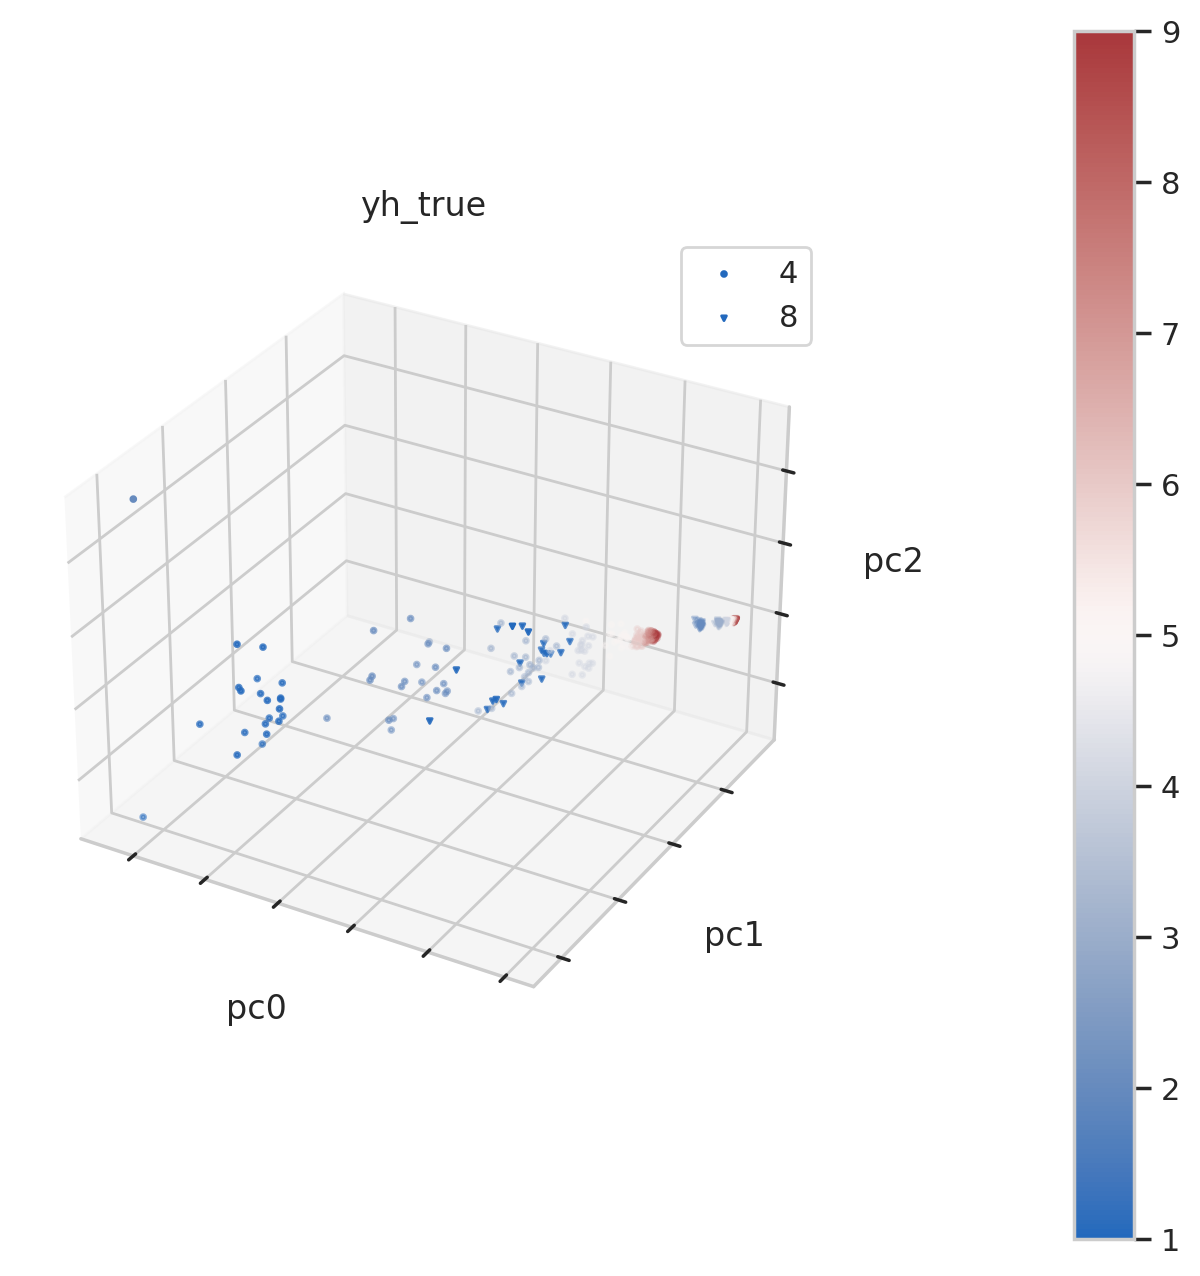

In [61]:
fn = 'yh_true'
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

plot_manifold(dc, r, fn=fn, d=3, key='numc', queries=[4, 8])

[-2.91023850e+05 -2.35982678e+04 -1.52041651e+04 -1.38248441e+04
 -1.33829292e+04  1.59340881e+03  5.82699893e+01  5.00202106e+01
  4.18006758e+01]
[-2.91023850e+05 -2.35982678e+04 -1.52041651e+04 -1.38248441e+04
 -1.33829292e+04  1.59340881e+03  5.82699893e+01  5.00202106e+01
  4.18006758e+01]


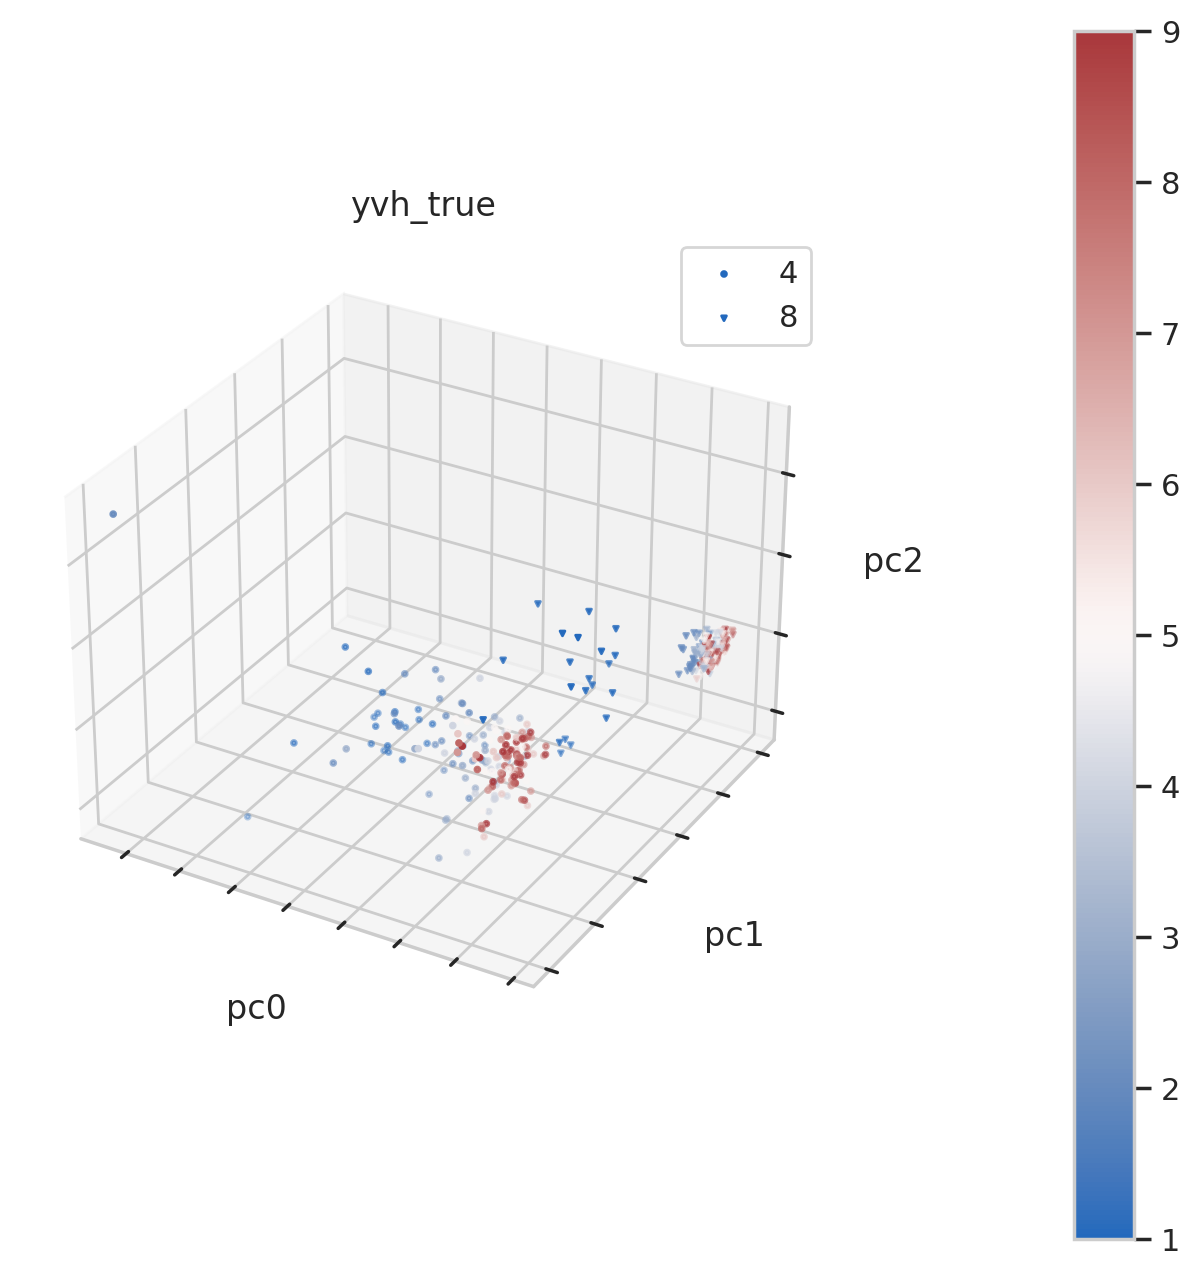

In [62]:
fn = 'yvh_true'
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

plot_manifold(dc, r, fn=fn, d=3, key='numc', queries=[4, 8])

In [63]:
loc = 'results/models/all-noise'

r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    k = json.loads(f[f.find('{'):f.find('}')+1])
    if 50<=k['seed']<=70 and k['widen'] ==4 and k['numc'] in [4,8]:
        d = th.load(f)
    #     print(f, len(d))
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

loc = 'inpca_results'
for key in ['yh', 'yvh']:
    fn = f'{key}_all_noise'
    embed(d, fn=fn, ss=2, key=key)

Index(['seed', 'widen', 'numc', 'noise_label', 't', 'yh', 'f', 'e', 'yvh',
       'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 630
chunks:  100


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


Saving w
Projecting
chunks:  100


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.52it/s]

Saving w
Projecting


[-4.38655315e+06  1.41492516e+05 -1.00714299e+05 -9.63872325e+04
 -8.40739403e+04 -7.99835404e+04  5.86123184e+03  3.19483079e+03
  2.55854889e+03]
[-4.38655315e+06  1.41492516e+05 -1.00714299e+05 -9.63872325e+04
 -8.40739403e+04 -7.99835404e+04  5.86123184e+03  3.19483079e+03
  2.55854889e+03]


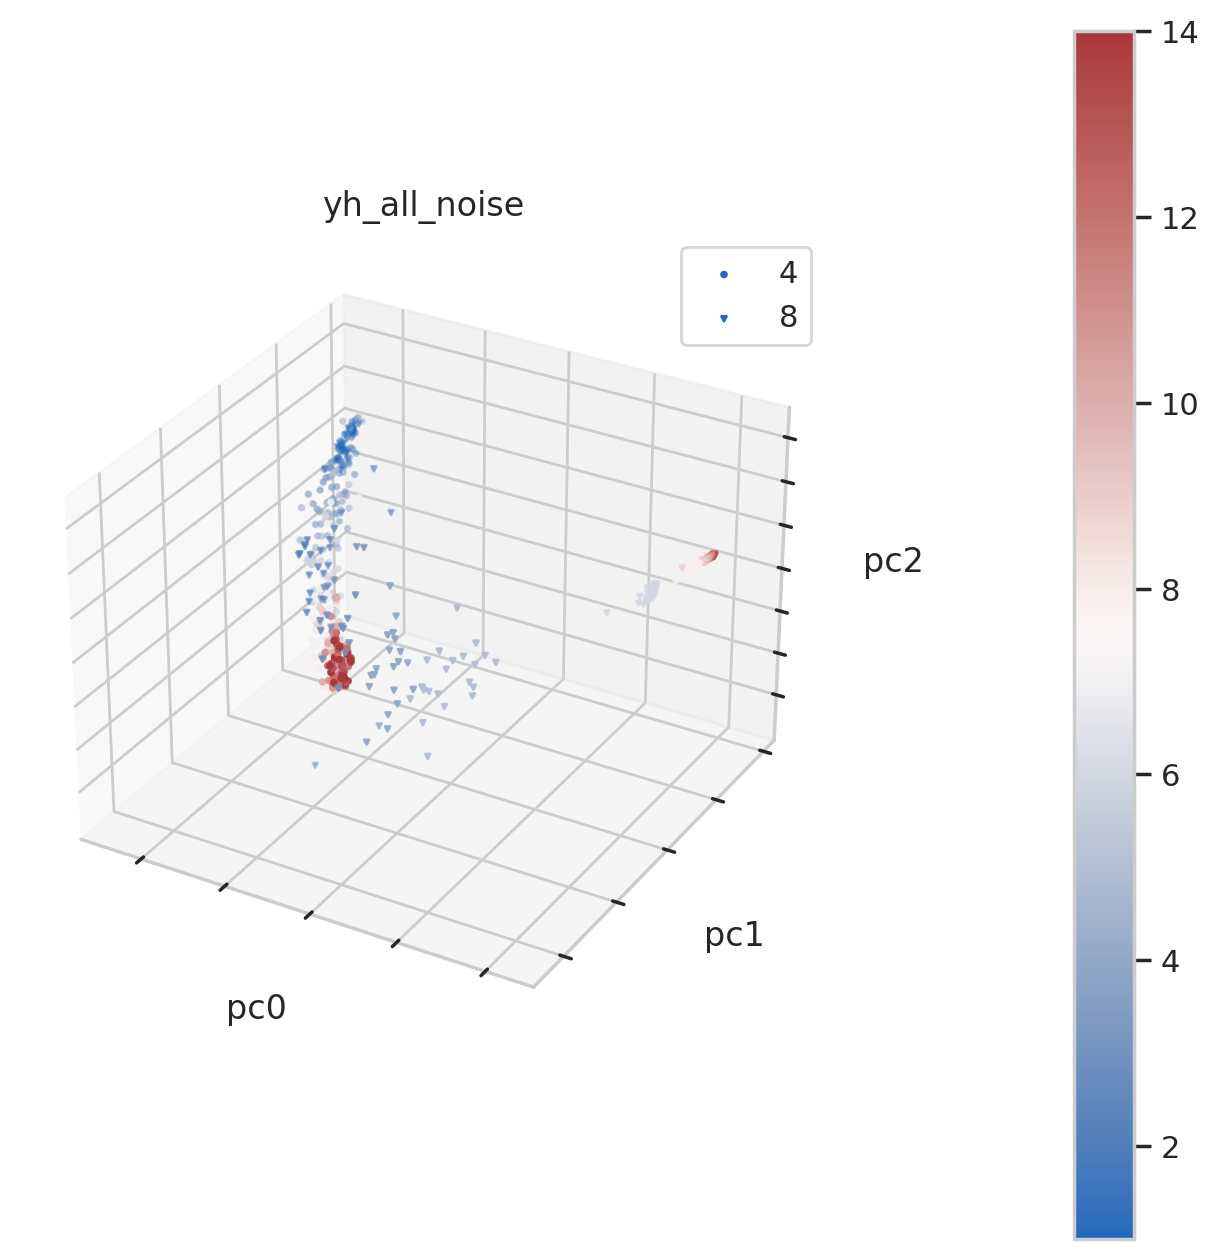

In [64]:
fn = 'yh_all_noise'
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

plot_manifold(dc, r, fn=fn, d=3, key='numc', queries=[4, 8])

[ 208017.88349306 -101557.37668757 -101198.3795234  -100927.43912853
  -98958.86267351  -98625.35182893    1448.12432381     568.25079549
     321.41718044]
[ 208017.88349306 -101557.37668757 -101198.3795234  -100927.43912853
  -98958.86267351  -98625.35182893    1448.12432381     568.25079549
     321.41718044]


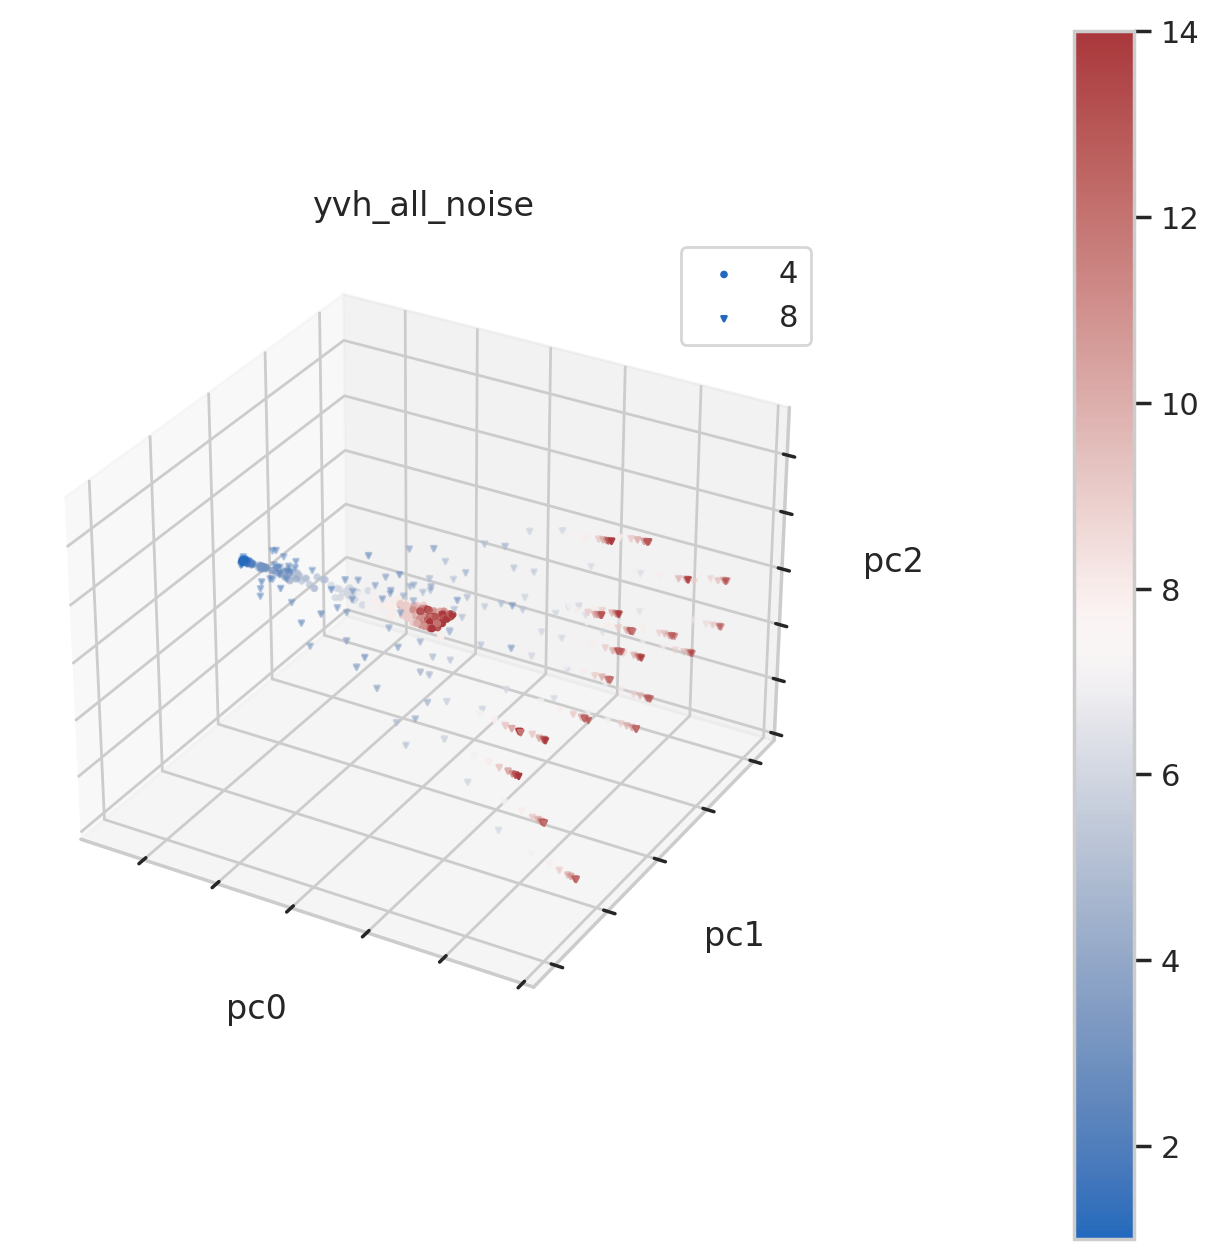

In [66]:
fn = 'yvh_all_noise'
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

plot_manifold(dc, r, fn=fn, d=3, key='numc', queries=[4, 8])

In [70]:
loc = 'results/models/relabel'

r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    k = json.loads(f[f.find('{'):f.find('}')+1])
    if 40<=k['seed']<=130:
        d = th.load(f)
    #     print(f, len(d))
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

loc = 'inpca_results'
idx = ['seed', 'widen', 'numc', 't', 'err', 'verr', 'favg', 'vfavg', 'relabel']
for key in ['yh', 'yvh']:
    fn = f'{key}_relabel'
    embed(d, fn=fn, ss=2, key=key, idx=idx)

Index(['seed', 'widen', 'numc', 'noise_label', 'relabel', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 900
Found:  inpca_results/w_yh_relabel.p
Projecting
Found:  inpca_results/w_yvh_relabel.p
Projecting


[-1510397.27919691  -341951.50560764  -206595.11530201  -164479.19452047
  -151325.48902485    33458.17238628     4655.73654191     2935.88102709
     2532.0232328 ]
[-1510397.27919691  -341951.50560764  -206595.11530201  -164479.19452047
  -151325.48902485    33458.17238628     4655.73654191     2935.88102709
     2532.0232328 ]
[-1510397.27919691  -341951.50560764  -206595.11530201  -164479.19452047
  -151325.48902485    33458.17238628     4655.73654191     2935.88102709
     2532.0232328 ]
[-1510397.27919691  -341951.50560764  -206595.11530201  -164479.19452047
  -151325.48902485    33458.17238628     4655.73654191     2935.88102709
     2532.0232328 ]
[-1510397.27919691  -341951.50560764  -206595.11530201  -164479.19452047
  -151325.48902485    33458.17238628     4655.73654191     2935.88102709
     2532.0232328 ]


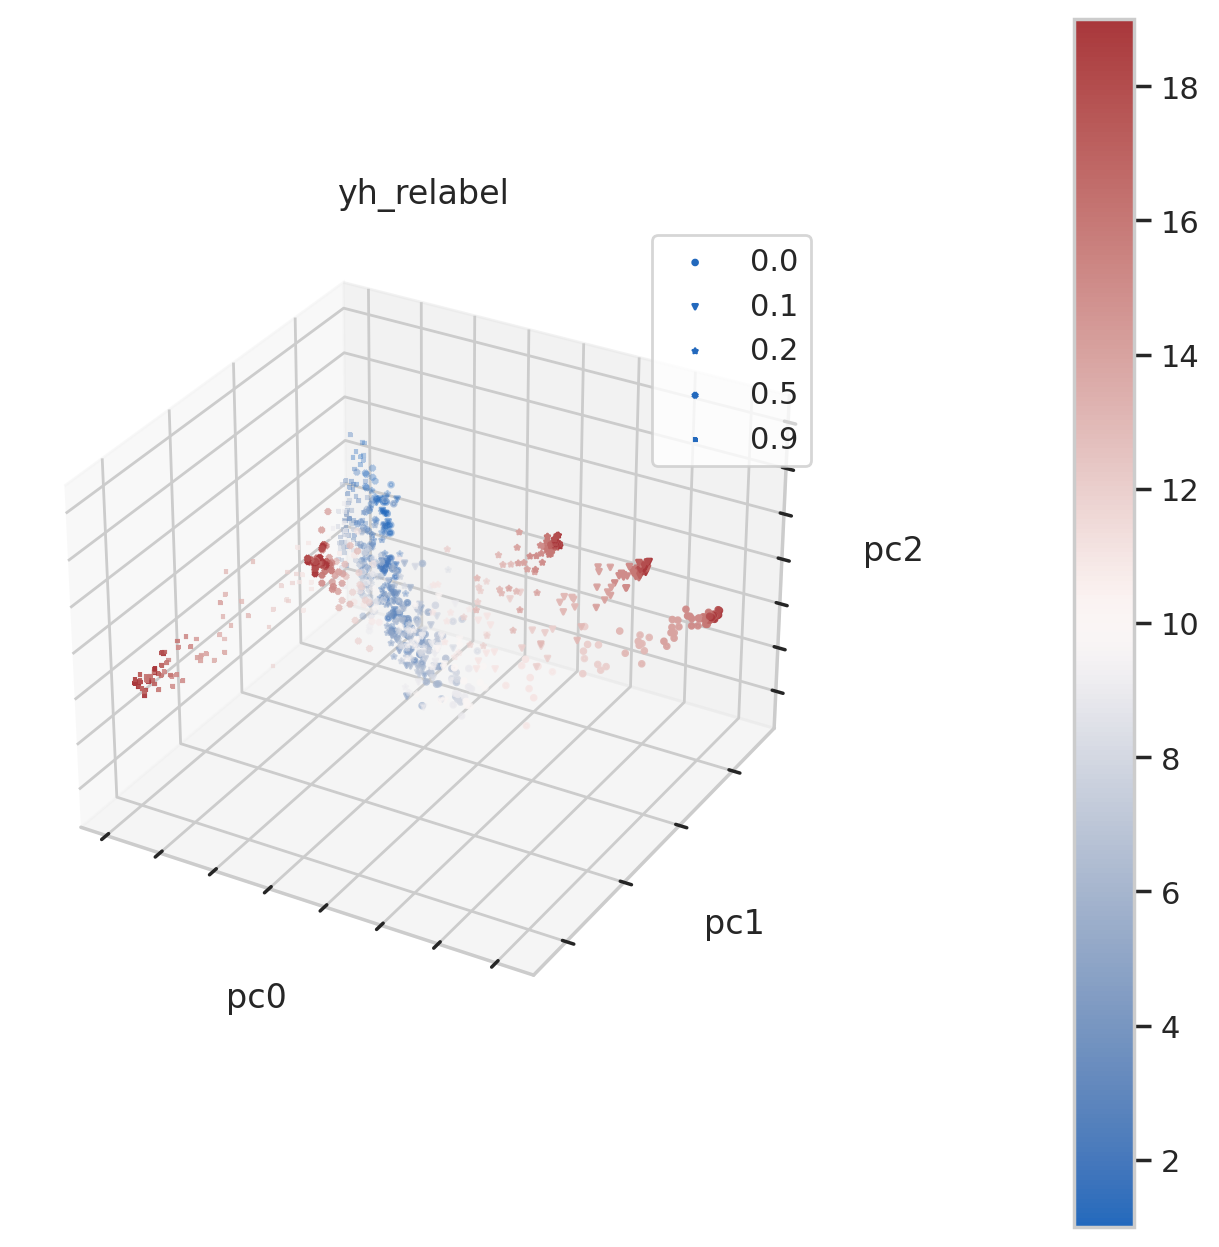

In [102]:
fn = 'yh_relabel'
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

plot_manifold(dc, r, fn=fn, d=3, key='relabel', queries=[0.0, 0.1, 0.2, 0.5, 0.9])

[-357087.99872499  -75959.36120662  -68542.39331054  -62759.41021284
  -52954.88750669   20850.51482998    1062.29952219     816.19489199
     668.29109636]
[-357087.99872499  -75959.36120662  -68542.39331054  -62759.41021284
  -52954.88750669   20850.51482998    1062.29952219     816.19489199
     668.29109636]
[-357087.99872499  -75959.36120662  -68542.39331054  -62759.41021284
  -52954.88750669   20850.51482998    1062.29952219     816.19489199
     668.29109636]
[-357087.99872499  -75959.36120662  -68542.39331054  -62759.41021284
  -52954.88750669   20850.51482998    1062.29952219     816.19489199
     668.29109636]
[-357087.99872499  -75959.36120662  -68542.39331054  -62759.41021284
  -52954.88750669   20850.51482998    1062.29952219     816.19489199
     668.29109636]


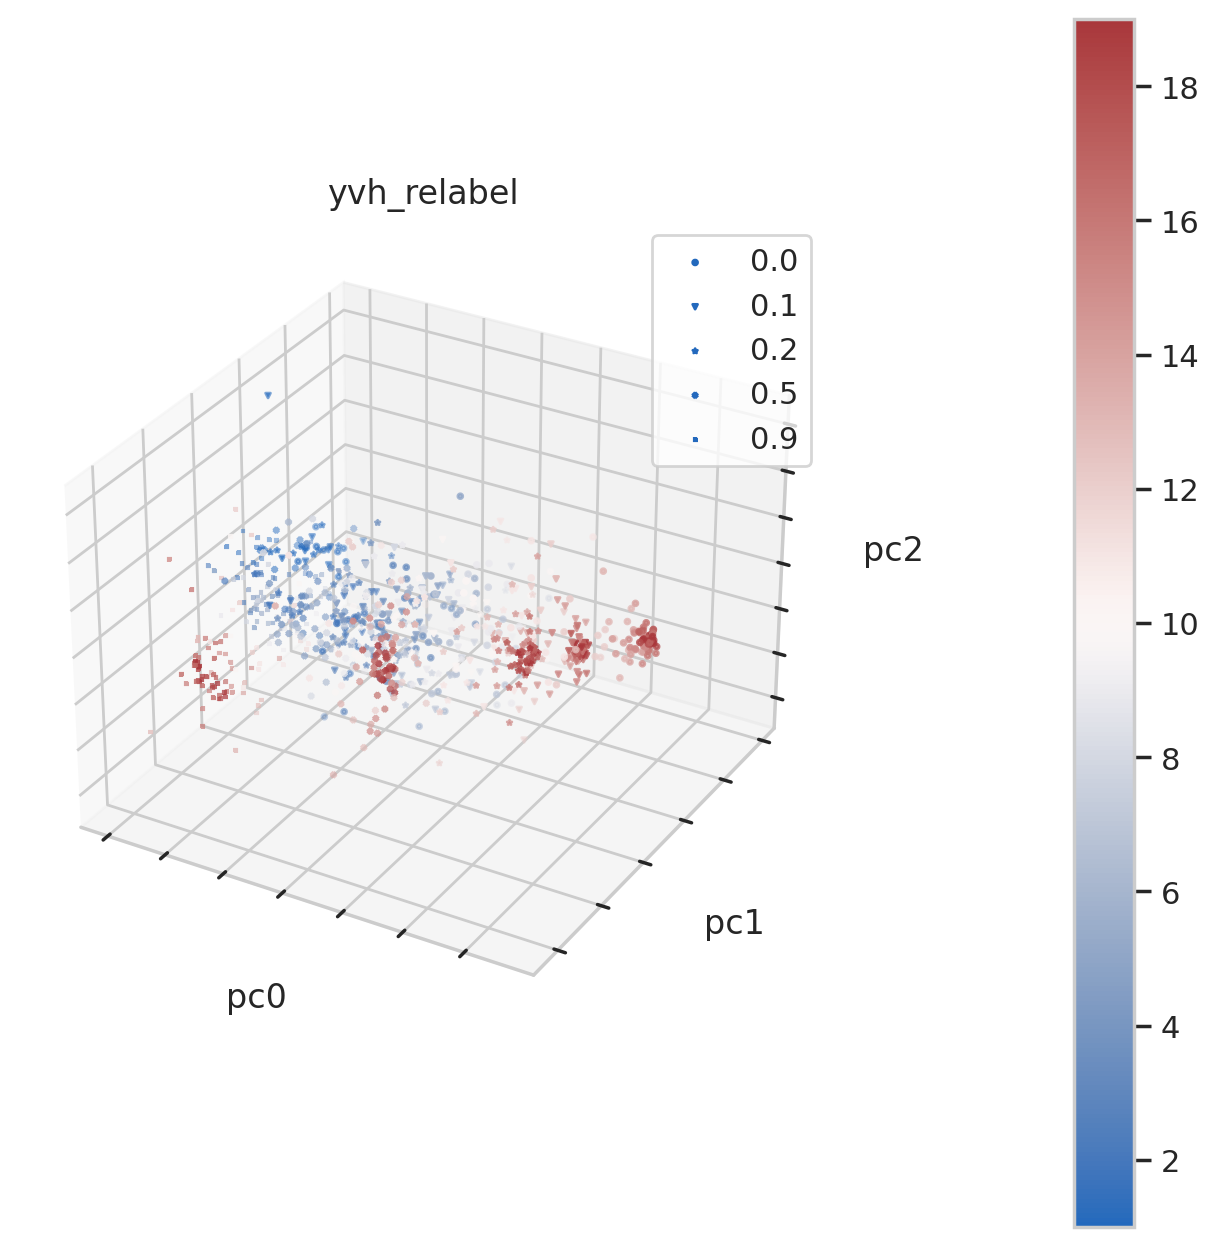

In [103]:
fn = 'yvh_relabel'
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

plot_manifold(dc, r, fn=fn, d=3, key='relabel', queries=[0.0, 0.1, 0.2, 0.5, 0.9])

<IPython.core.display.Javascript object>


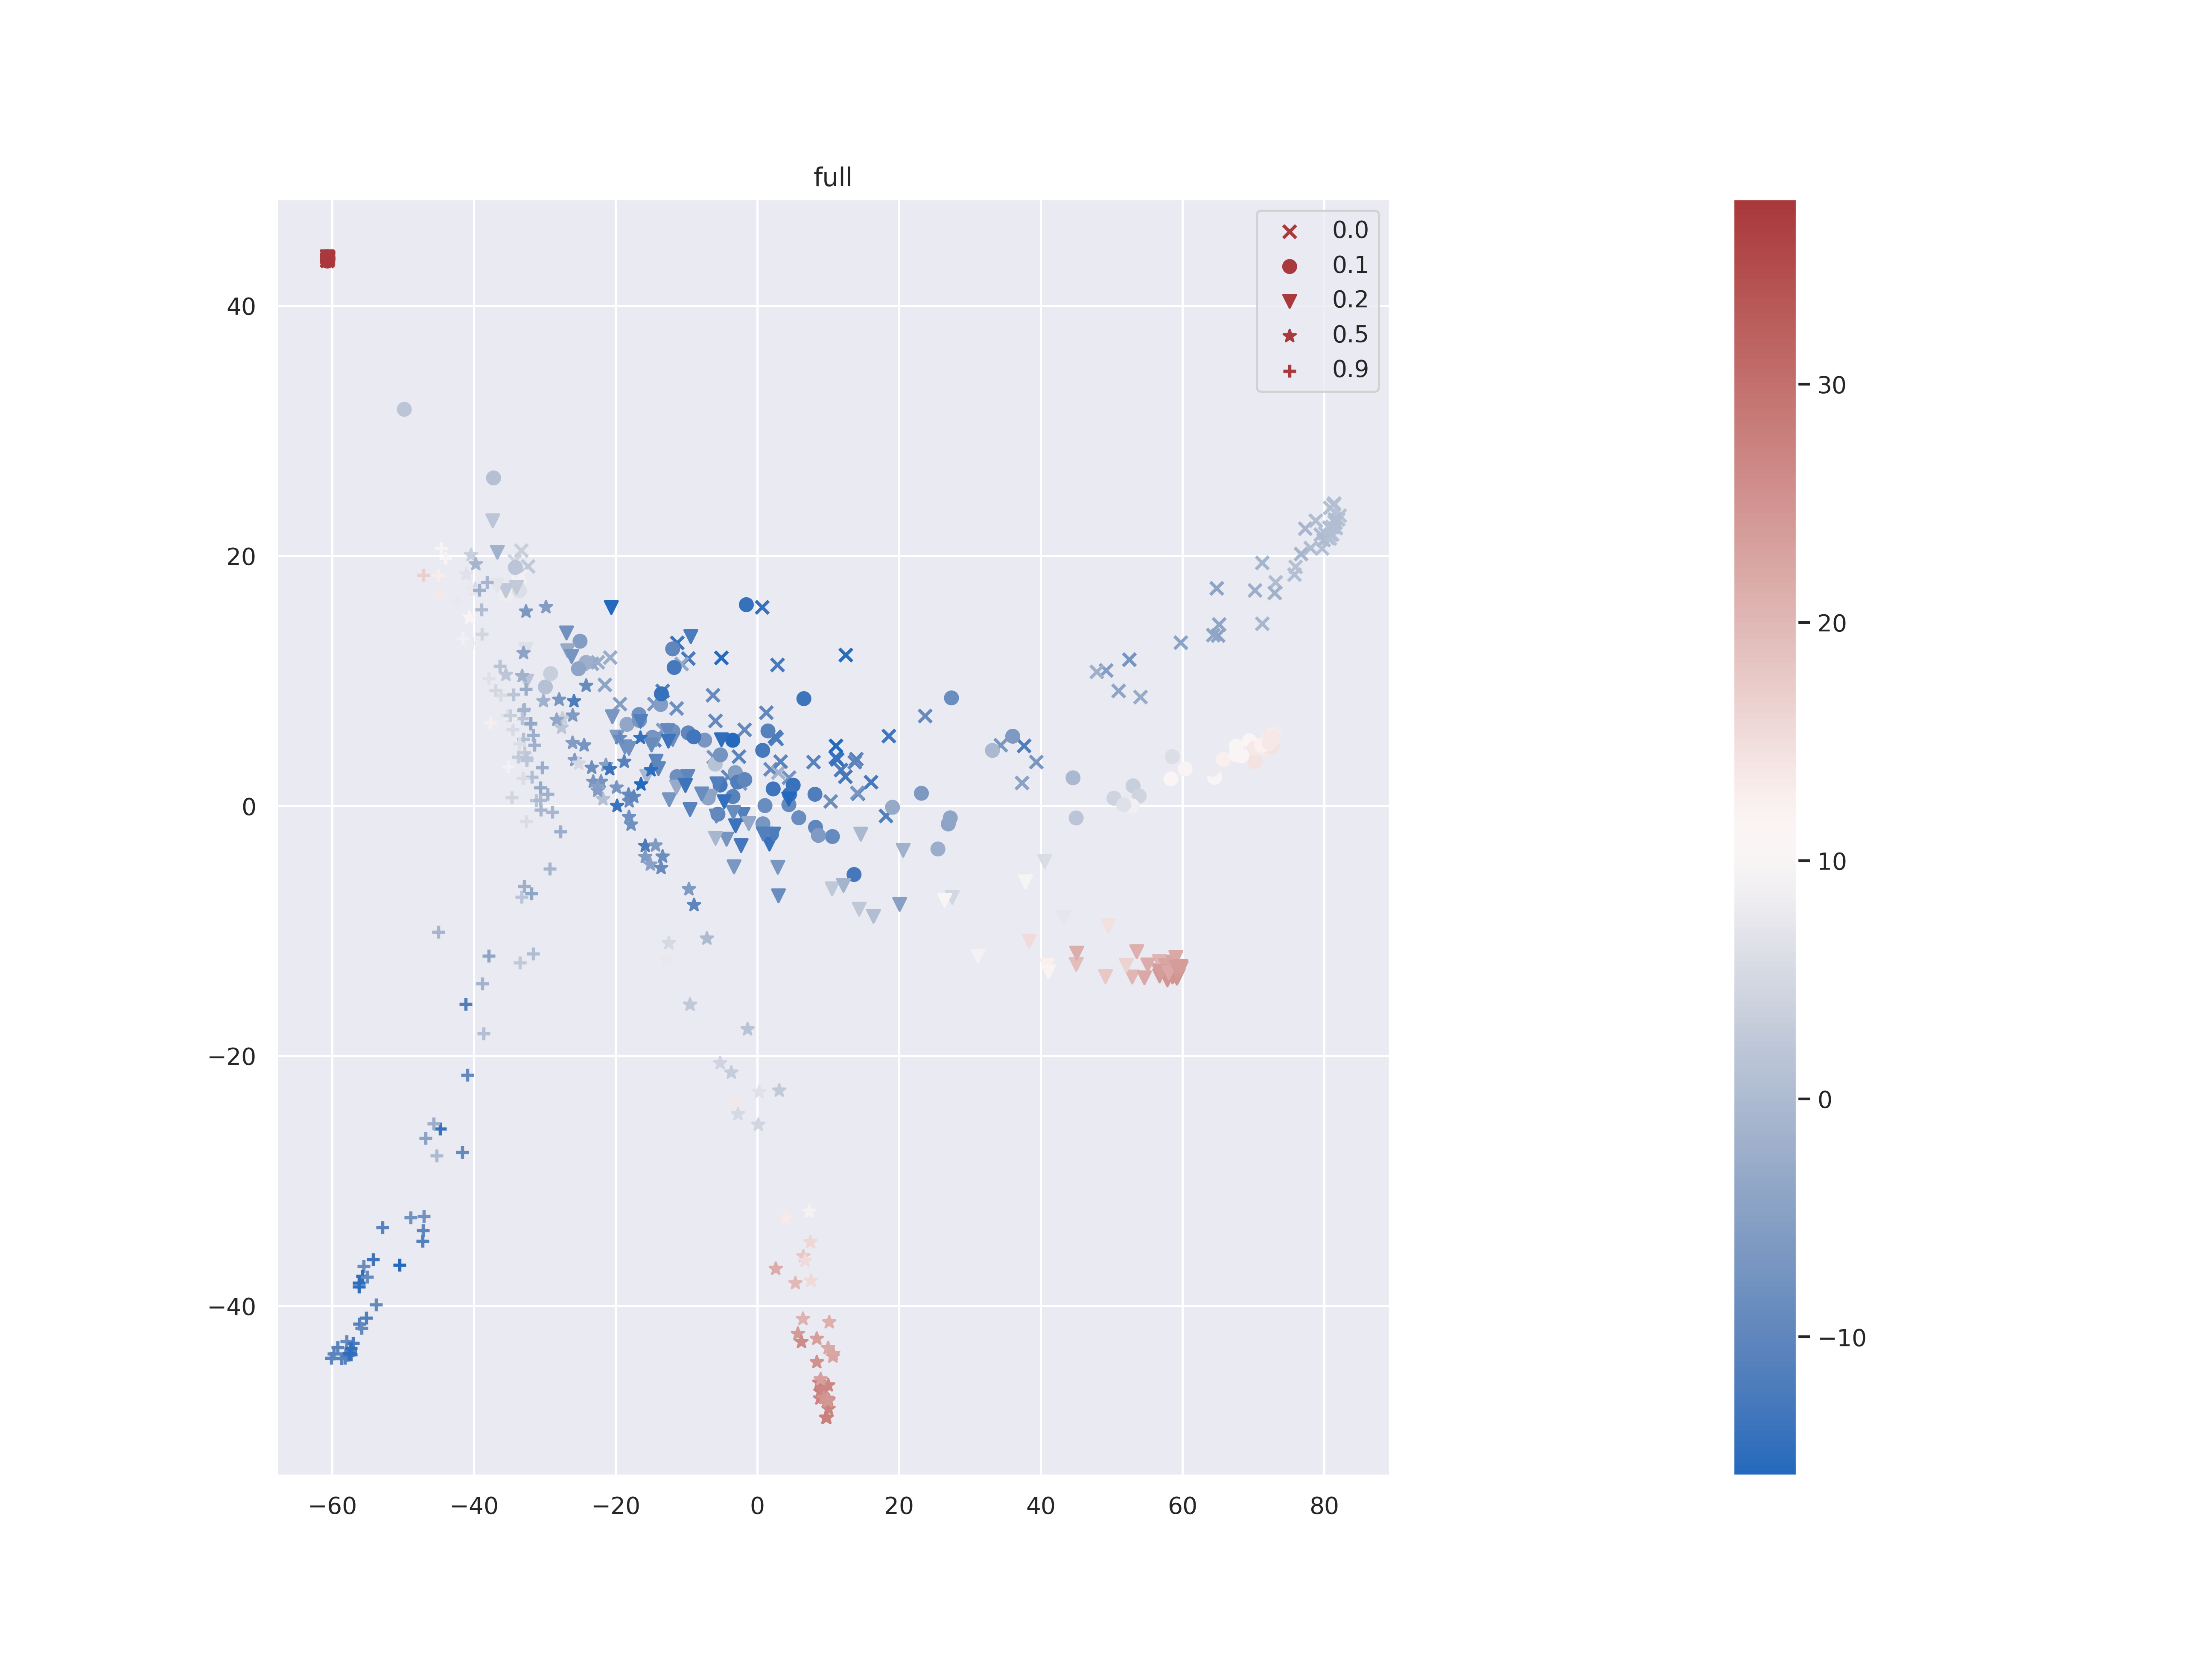

In [64]:
markers = ['x', 'o', 'v', '*', '+']
fig = plt.figure(1, figsize=(8,6))
plt.clf();
ax = fig.add_subplot()
for (i, frac) in enumerate([0.0, 0.1, 0.2, 0.5, 0.9]):
    ii = get_idx(f'relabel=={frac}')
    xx = r['xp'][ii]
    sc = ax.scatter(xx[:, 0], xx[:, 1], c=xx[:, 2], cmap='vlag', label=frac,  marker=markers[i])
# ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
plt.colorbar(sc, pad=0.2);
plt.title(fn);
ax.legend()

In [11]:
plt.savefig('manifold_2.pdf', bbox_inches='tight')

In [ ]:
plt.figure(2); plt.clf(); plt.plot(np.abs(ee)); plt.yscale('log');

In [ ]:
ee_skl = np.array([-164083.41656593,   -5567.04529202,   -5188.73140228,
         -3968.06433274,   -3330.35466684,    2211.74081369,
           539.23097939,     462.12525554,     437.12668961])

In [ ]:
ee_bhat = ee

In [ ]:
plt.figure(2); plt.clf(); plt.plot(np.abs(ee), label='bhat'); plt.plot(np.abs(ee_skl), label='skl'); plt.yscale('log'); plt.legend()

In [104]:
import numpy as np
from scipy.stats import pearsonr
from sklearn import linear_model
from math import sqrt
from scipy.spatial.distance import pdist, squareform

                     
def estimate(X,fraction=0.9,verbose=False):    

    # sort distance matrix
    Y = np.sort(X,axis=1,kind='quicksort')

    # clean data
    k1 = Y[:,1]
    k2 = Y[:,2]

    zeros = np.where(k1 == 0)[0]
    if verbose:
        print('Found n. {} elements for which r1 = 0'.format(zeros.shape[0]))
        print(zeros)

    degeneracies = np.where(k1 == k2)[0]
    if verbose:
        print('Found n. {} elements for which r1 = r2'.format(degeneracies.shape[0]))
        print(degeneracies)

    good = np.setdiff1d(np.arange(Y.shape[0]), np.array(zeros) )
    good = np.setdiff1d(good,np.array(degeneracies))
    
    if verbose:
        print('Fraction good points: {}'.format(good.shape[0]/Y.shape[0]))
    
    k1 = k1[good]
    k2 = k2[good]    
    
    # n.of points to consider for the linear regression
    npoints = int(np.floor(good.shape[0]*fraction))

    # define mu and Femp
    N = good.shape[0]
    mu = np.sort(np.divide(k2, k1), axis=None,kind='quicksort')
    Femp = (np.arange(1,N+1,dtype=np.float64) )/N
    
    # take logs (leave out the last element because 1-Femp is zero there)
    x = np.log(mu[:-2])
    y = -np.log(1 - Femp[:-2])

    # regression
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(x[0:npoints,np.newaxis],y[0:npoints,np.newaxis]) 
    r,pval = pearsonr(x[0:npoints], y[0:npoints])  
    return x,y,regr.coef_[0][0],r,pval                    
  

In [126]:
loc = 'results/models/relabel'

r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    k = json.loads(f[f.find('{'):f.find('}')+1])
    if 40<=k['seed']<=130:
        d = th.load(f)
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)
idx = idx or ['seed', 't', 'err', 'verr', 'favg', 'vfavg']
dc = d[idx]

for (i, frac) in enumerate([0.0, 0.1, 0.2, 0.5, 0.9]):
    
    ii = get_idx(d, f'relabel=={frac}')
    x = np.array([d.iloc[i]['yh'][::2].float().numpy()[ii, :] for i in range(len(d))])
    n = x.shape[0]
    
    a = np.sqrt(np.exp(x))
    a = np.moveaxis(a, 0, 1)
    w = np.zeros((n,n))
    nc = 90
    print('chunks: ', nc)
    for aa in tqdm.tqdm(np.split(a, nc)):
        w += np.log(np.einsum('kil,kjl->kij', aa, aa, optimize=True)).sum(0)
    w = -w
    _, _, dim, _, _ = estimate(w)
    print(frac, dim)

chunks:  90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.73it/s]


0.0 3.1929104379108506
chunks:  90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.76it/s]


0.1 3.321657425072369
chunks:  90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.71it/s]


0.2 3.3009132019315826
chunks:  90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.70it/s]


0.5 3.2780243568014233
chunks:  90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.72it/s]

0.9 3.20669556199209


In [125]:
a.shape

(180, 900, 10)

In [118]:
ii = get_idx(d, f'relabel=={frac}')

### Noisy labels

In [ ]:
# loc = 'inpca_results_noise_wrong'
loc = 'results'

In [ ]:
r = []
for f in glob.glob(os.path.join(loc, '*.p')):
    if f.find('{') > 0:
        k = json.loads(f[f.find('{'):-2])
        d = th.load(f)
        for i in range(len(d)):
            t = {}
            t.update(k)
            t.update({'t': i})
            t.update(d[i])
            r.append(t)

d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

In [ ]:
r = embed(d, fn='noise_full', ss=2, key='yh', force=True)

In [2]:
loc = 'results'
fn = 'full_noise'

r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

get_idx = lambda c: dc.query(c).index.tolist()

<IPython.core.display.Javascript object>


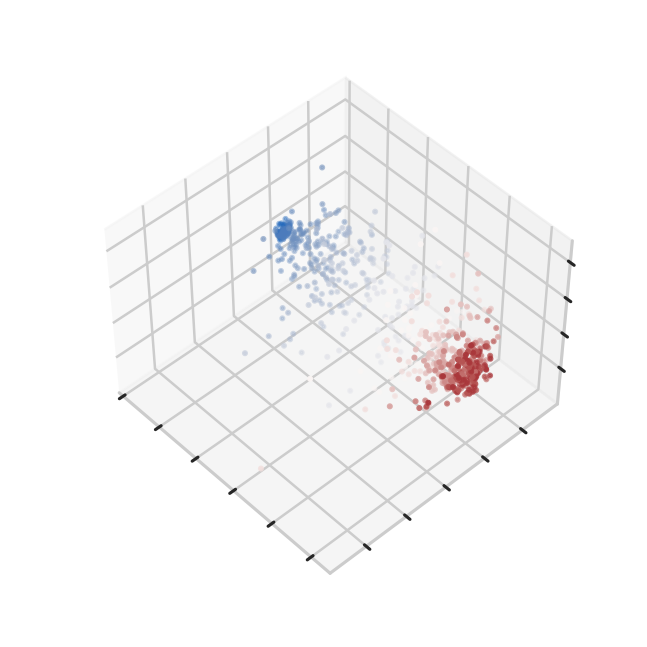

In [3]:
ii = get_idx('t >= 0 & widen == 4 and numc == 4')
xx = r['xp'][ii]
ee = r['e']
# print(ee[:3])
c = dc['t'][ii]

fig = plt.figure(3)
plt.clf();
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                c=c, s=2, cmap='vlag')
# ax.set_xlabel('pc0'); ax.set_ylabel('pc1'); ax.set_zlabel('pc2');
# plt.colorbar(sc, pad=0.2);
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
# plt.title(loc);

In [4]:
plt.savefig('manifold_noisy.pdf', bbox_inches='tight')

In [ ]:
plt.figure(4); plt.clf(); plt.plot(np.abs(ee)); plt.yscale('log');